In [4]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
%matplotlib widget
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
import torch
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import torchCompactRadius

In [5]:
import torchCompactRadius_cuda

In [6]:
import numpy as np
import torchCompactRadius as tcr
from torchCompactRadius import radiusSearch, volumeToSupport
from torchCompactRadius.util import countUniqueEntries
# from torchCompactRadius.radiusNaive import radiusNaive, radiusNaiveFixed
# from torchCompactRadius.cppWrapper import neighborSearchSmall, neighborSearchSmallFixed
import platform
# import pandas as pd
import time
# from tqdm.autonotebook import tqdm
import copy
# import seaborn as sns

def generateNeighborTestData(nx, targetNumNeighbors, dim, maxDomain_0, periodic, device):


    minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
    maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
    maxDomain[0] = maxDomain_0
    periodicity = torch.tensor([periodic] * dim, device = device, dtype = torch.bool)

    extent = maxDomain - minDomain
    shortExtent = torch.min(extent, dim = 0)[0].item()
    dx = (shortExtent / nx)
    ny = int(1 // dx)
    h = volumeToSupport(dx**dim, targetNumNeighbors, dim)
    dy = dx / 1.5
    ny = int(1 // dy)

    # print(f"dx = {dx}, dy = {dy}, h = {h}")
    # print(f"nx = {nx}, ny = {ny}")
    # print(f"minDomain = {minDomain}, maxDomain = {maxDomain}")
    # print(f"periodicity = {periodicity}")
    # print(f"dim = {dim}")
    # print(f"device = {device}")
    # print(f"maxDomain_0 = {maxDomain_0}")
    # print(f"targetNumNeighbors = {targetNumNeighbors}")
    

    positions = []
    for d in range(dim):
        positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
    grid = torch.meshgrid(*positions, indexing = 'xy')
    positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    supports = torch.ones(positions.shape[0], device = device) * h
    ypositions = []
    for d in range(dim):
        ypositions.append(torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny, device = device))
    grid = torch.meshgrid(*ypositions, indexing = 'xy')
    y = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
    ySupport = torch.ones(y.shape[0], device = device) * volumeToSupport(dy**dim, targetNumNeighbors, dim)
    return (y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, positions.shape[0]

def test_ij(i, j, y, positions, periodic):
    try:
        if y.shape == positions.shape and torch.all(y == positions):
            if torch.any(periodic):
                assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
                assert i.shape[0] == 46080, f'i.shape[0] = {i.shape[0]} != 11520'
                assert j.shape[0] == 46080, f'i.shape[0] = {j.shape[0]} != 11520'
                ii, ni = countUniqueEntries(i, y)
                jj, nj = countUniqueEntries(j, positions)
                assert ni.min() == ni.max(), f'ni.min() = {ni.min()} != ni.max() = {ni.max()}'
                assert ni.min() == 45, f'ni.min() = {ni.min()} != 45'
                print('✅', end = '')
            else:
                assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
                assert i.shape[0] == 41580, f'i.shape[0] = {i.shape[0]} != 41580'
                assert j.shape[0] == 41580, f'i.shape[0] = {j.shape[0]} != 41580'
                ii, ni = countUniqueEntries(i, y)
                jj, nj = countUniqueEntries(j, positions)
                assert ni.min() != ni.max(), f'ni.min() = {ni.min()} == ni.max() = {ni.max()}'
                assert nj.min() != nj.max(), f'nj.min() = {nj.min()} == nj.max() = {nj.max()}'

                assert ni.min() == 15, f'ni.min() = {ni.min()} != 15'
                assert ni.max() == 45, f'ni.min() = {ni.min()} != 45'
                print('✅', end = '')
        else:
            assert i.shape[0] == j.shape[0], f'i.shape[0] = {i.shape[0]} != j.shape[0] = {j.shape[0]}'
            assert i.shape[0] == 11520, f'i.shape[0] = {i.shape[0]} != 11520'
            assert j.shape[0] == 11520, f'i.shape[0] = {j.shape[0]} != 11520'
            ii, ni = countUniqueEntries(i, y)
            jj, nj = countUniqueEntries(j, positions)
            assert ni.min() == ni.max(), f'ni.min() = {ni.min()} != ni.max() = {ni.max()}'
            assert ni.min() == 45, f'ni.min() = {ni.min()} != 45'
            print('✅', end = '')
    except AssertionError as e:
        print('❌', end = '')



In [7]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 2
periodic = False
(y, x), (ySupport, xSupport), (minDomain, maxDomain), periodicity, hashMapLength = generateNeighborTestData(nx, targetNumNeighbors, dim, 1.0, False, device)
h = ySupport[0].cpu().item()

from torchCompactRadius.util import DomainDescription, PointCloud

minDomain *= 2
maxDomain *= 2
domainDescription = DomainDescription(minDomain, maxDomain, periodicity, dim)

pointCloudX = PointCloud(x, xSupport)
pointCloudY = PointCloud(y, ySupport)

# pointCloudX = PointCloud(x, None)
# pointCloudY = PointCloud(y, None)

In [8]:
# i, j = radiusSearch(pointCloudY, pointCloudX, supportOverride= h, algorithm = 'compact', domain = domainDescription, verbose = True)
# test_ij(i, j, y, x, periodic)
# i, j = radiusSearch(pointCloudX, pointCloudY, supportOverride= h, algorithm = 'compact', domain = domainDescription)
# test_ij(j, i, y, x, periodic)

[X] Min Supports: 0.20802053809165955, Max Supports: 2.0
[Y] Min Supports: 0.12453529238700867, Max Supports: 1.0055688619613647


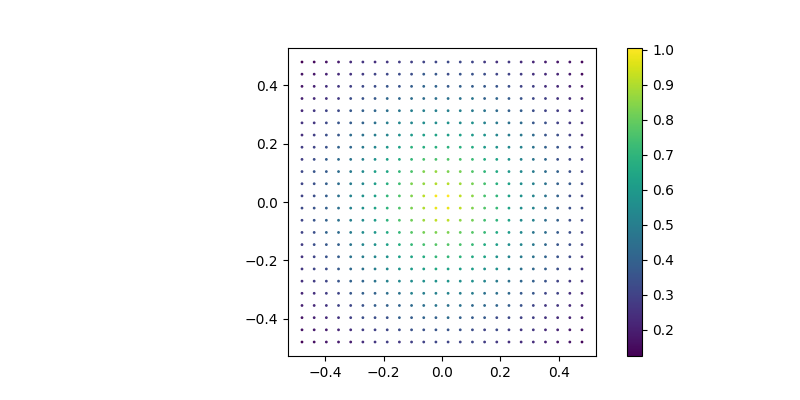

In [9]:
pointCloudX.supports = xSupport + torch.randn_like(xSupport) * xSupport.max() / 16 + (1 - torch.linalg.norm(x, dim = -1))**2 * xSupport.max() * 8
pointCloudY.supports = ySupport + torch.randn_like(ySupport) * ySupport.max() / 16 + (1 - torch.linalg.norm(y, dim = -1))**2 * xSupport.min() * 4 - 0.125

pointCloudX.supports = pointCloudX.supports.clamp(max = (domainDescription.max - domainDescription.min).min() / 2)

import matplotlib.pyplot as plt
fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze=False)

sc = axis[0,0].scatter(y[:,0], y[:,1], s = 1, c = pointCloudY.supports.cpu().numpy())
fig.colorbar(sc, ax = axis[0,0])

axis[0,0].set_aspect('equal')

print(f'[X] Min Supports: {pointCloudX.supports.min()}, Max Supports: {pointCloudX.supports.max()}')
print(f'[Y] Min Supports: {pointCloudY.supports.min()}, Max Supports: {pointCloudY.supports.max()}')


In [10]:

    
# hCell, qCells = computeCellResolution(domainDescription, pointCloudX.supports.min())

In [11]:
from torchCompactRadius.multiLevelMemory.cellOp import computeResolutionLevels


3 [(0, 0.25, tensor([16., 16.])), (1, 0.5, tensor([8., 8.])), (2, 1.0, tensor([4., 4.]))] 0.25 1.201804409763824
level.min() = 0, level.max() = 2


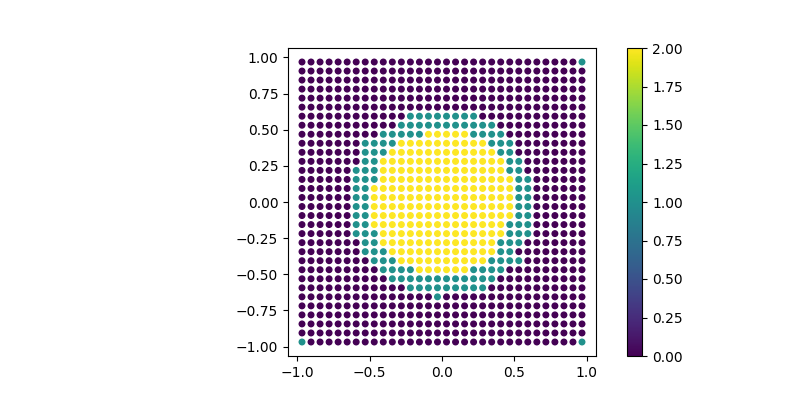

In [12]:
hMin = pointCloudX.supports.min().cpu().item()
hMax = pointCloudX.supports.max().cpu().item()

levels, levelResolutions, hCell, hVerlet = computeResolutionLevels(domainDescription, hMin, hMax)
print(levels, levelResolutions, hCell, hVerlet)

level = pointCloudX.supports / hCell
level = torch.floor(level)
level = torch.clamp(level, 1, levels)
level = level.int() - 1

print(f'level.min() = {level.min()}, level.max() = {level.max()}')

fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze=False)
sc = axis[0,0].scatter(x[:,0], x[:,1], s = 16, c = level.cpu().numpy())
fig.colorbar(sc, ax = axis[0,0])
axis[0,0].set_aspect('equal')

In [13]:
from torchCompactRadius.multiLevelMemory.indexing import mortonEncode, mortonDecode, getMortonCodes



codes = getMortonCodes(x, hCell, domainDescription, levels)

[tensor([ 48,  48,  48,  ..., 207, 207, 207], dtype=torch.int32), tensor([12, 12, 12,  ..., 51, 51, 51], dtype=torch.int32), tensor([ 3,  3,  3,  ..., 12, 12, 12], dtype=torch.int32)]


(-2.0, 2.0)

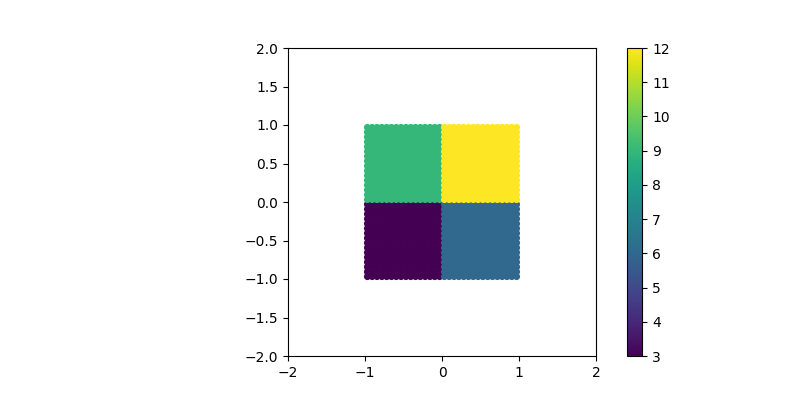

In [14]:
xi = ((x[:,0] - domainDescription.min[0]) / hCell).int()
yi = ((x[:,1] - domainDescription.min[1]) / hCell).int()
# mort = Z_encode2D(xi, yi)


print(codes)

i_ = mortonDecode(codes[0], dim = 2)
xi_ = i_[:,0]
yi_ = i_[:,1]
assert torch.all(xi == xi_)
assert torch.all(yi == yi_)

fig, axis = plt.subplots(1,1, figsize = (8,4), squeeze=False)
sc = axis[0,0].scatter(x[:,0], x[:,1], s = 16, c = codes[-1].cpu().numpy())
fig.colorbar(sc, ax = axis[0,0])
axis[0,0].set_aspect('equal')
axis[0,0].set_xlim(minDomain[0], maxDomain[0])
axis[0,0].set_ylim(minDomain[1], maxDomain[1])

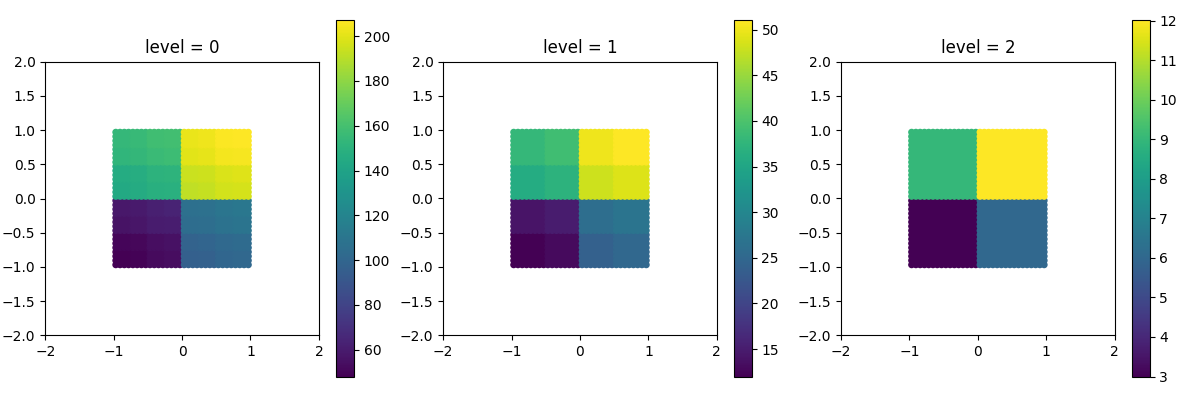

In [15]:
sortingIndices = torch.argsort(codes[0])

sortedPositions = x[sortingIndices]
sortedSupports = pointCloudX.supports[sortingIndices]
sortedCodes = [code[sortingIndices] for code in codes]

fig, axis = plt.subplots(1,len(sortedCodes), figsize = (len(sortedCodes)* 4,4), squeeze=False)
for i, code in enumerate(sortedCodes):
    sc = axis[0,i].scatter(sortedPositions[:,0], sortedPositions[:,1], s = 16, c = code.cpu().numpy())
    fig.colorbar(sc, ax = axis[0,i])
    axis[0,i].set_aspect('equal')
    axis[0,i].set_title(f'level = {i}')
    axis[0,i].set_xlim(minDomain[0], maxDomain[0])
    axis[0,i].set_ylim(minDomain[1], maxDomain[1])
fig.tight_layout()

In [16]:
# print(levelResolutions[0])

In [17]:
from torchCompactRadius.multiLevelMemory.cellData import buildDenseCellData, buildSparseCellData
from torchCompactRadius.multiLevelMemory.cellOp import mergeCells
from torchCompactRadius.multiLevelMemory.indexing import mortonDecode


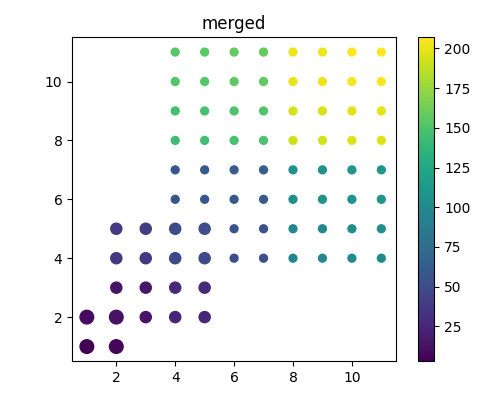

In [18]:


cells = []
for il, level in enumerate(levelResolutions):
    cells.append(buildSparseCellData(sortedCodes[il], level))    
mergedCells = mergeCells(cells)


cellsDense = []
for il, level in enumerate(levelResolutions):
    cellsDense.append(buildDenseCellData(sortedCodes[il], level))    
mergedDenseCells = mergeCells(cellsDense)


fig, axis = plt.subplots(1, 1, figsize = (5, 4), squeeze=False)
baseExtent = torch.prod(levelResolutions[0][2].int()).cpu().item()
cellIndices = mergedCells.cellIndices #- mergedCells.cellLevel * baseExtent
decodedCell = mortonDecode(cellIndices, dim = dim)
decodedCellX = decodedCell[:,0]
decodedCellY = decodedCell[:,1]
cellCounters = mergedCells.cellCounters
sc = axis[0,0].scatter(decodedCellX.cpu().numpy(), decodedCellY.cpu().numpy(), s = 32 * ( 1 + mergedCells.cellLevel.cpu().numpy()), c = cellIndices.cpu().numpy())
fig.colorbar(sc, ax = axis[0,0])
axis[0,0].set_aspect('equal')
axis[0,0].set_title(f'merged')

fig.tight_layout()

In [19]:
from torchCompactRadius.multiLevelMemory.hashData import buildHashMap

In [20]:

hashMapLength = 32
hashMapData = buildHashMap(cells[0], hashMapLength, dim = dim)

for h in range(hashMapLength):
    print(f'hash = {h}, offset = {hashMapData.hashMapOffset[h]}, occupancy = {hashMapData.hashMapOccupancy[h]}')
    for i in range(hashMapData.hashMapOffset[h], hashMapData.hashMapOffset[h] + hashMapData.hashMapOccupancy[h]):
        print(f'    cell = {hashMapData.sortedCells[i]}, morton = {cells[0].cellIndices[hashMapData.sortedCells[i]]}, hash = {hashMapData.hashedIndices[hashMapData.sortedCells[i]]}')

hash = 0, offset = 0, occupancy = 3
    cell = 48, morton = 192, hash = 0
    cell = 47, morton = 159, hash = 0
    cell = 19, morton = 99, hash = 0
hash = 1, offset = 3, occupancy = 3
    cell = 17, morton = 97, hash = 1
    cell = 26, morton = 106, hash = 1
    cell = 45, morton = 157, hash = 1
hash = 2, offset = 6, occupancy = 2
    cell = 39, morton = 151, hash = 2
    cell = 24, morton = 104, hash = 2
hash = 3, offset = 8, occupancy = 3
    cell = 46, morton = 158, hash = 3
    cell = 37, morton = 149, hash = 3
    cell = 18, morton = 98, hash = 3
hash = 4, offset = 11, occupancy = 3
    cell = 15, morton = 63, hash = 4
    cell = 16, morton = 96, hash = 4
    cell = 44, morton = 156, hash = 4
hash = 5, offset = 14, occupancy = 2
    cell = 38, morton = 150, hash = 5
    cell = 13, morton = 61, hash = 5
hash = 6, offset = 16, occupancy = 3
    cell = 7, morton = 55, hash = 6
    cell = 36, morton = 148, hash = 6
    cell = 43, morton = 155, hash = 6
hash = 7, offset = 19, occupanc

In [21]:
mergedHashMapData = buildHashMap(mergedCells, hashMapLength, dim = dim)
for h in range(hashMapLength):
    print(f'hash = {h}, offset = {mergedHashMapData.hashMapOffset[h]}, occupancy = {mergedHashMapData.hashMapOccupancy[h]}')
    for i in range(mergedHashMapData.hashMapOffset[h], mergedHashMapData.hashMapOffset[h] + mergedHashMapData.hashMapOccupancy[h]):
        print(f'    cell = {mergedHashMapData.sortedCells[i]}, level = {mergedCells.cellLevel[mergedHashMapData.sortedCells[i]]} morton = {mergedCells.cellIndices[mergedHashMapData.sortedCells[i]]}, hash = {mergedHashMapData.hashedIndices[mergedHashMapData.sortedCells[i]]}')

hash = 0, offset = 0, occupancy = 3
    cell = 19, level = 0 morton = 99, hash = 0
    cell = 47, level = 0 morton = 159, hash = 0
    cell = 48, level = 0 morton = 192, hash = 0
hash = 1, offset = 3, occupancy = 3
    cell = 45, level = 0 morton = 157, hash = 1
    cell = 17, level = 0 morton = 97, hash = 1
    cell = 26, level = 0 morton = 106, hash = 1
hash = 2, offset = 6, occupancy = 2
    cell = 24, level = 0 morton = 104, hash = 2
    cell = 39, level = 0 morton = 151, hash = 2
hash = 3, offset = 8, occupancy = 3
    cell = 46, level = 0 morton = 158, hash = 3
    cell = 18, level = 0 morton = 98, hash = 3
    cell = 37, level = 0 morton = 149, hash = 3
hash = 4, offset = 11, occupancy = 3
    cell = 44, level = 0 morton = 156, hash = 4
    cell = 15, level = 0 morton = 63, hash = 4
    cell = 16, level = 0 morton = 96, hash = 4
hash = 5, offset = 14, occupancy = 2
    cell = 38, level = 0 morton = 150, hash = 5
    cell = 13, level = 0 morton = 61, hash = 5
hash = 6, offset = 1

In [22]:
# fig, axis = plt.subplots(1, len(cells), figsize = (4 * len(cells), 4), squeeze=False)
# for i, cell in enumerate(cells):
#     cellIndices = cell.cellIndices#.reshape(levelResolutions[i][2].int().cpu().numpy().tolist())
#     # cellBegins = cell.cellBegin.reshape(levelResolutions[i][2].int().cpu().numpy().tolist())
#     # cellEnds = cell.cellEnd.reshape(levelResolutions[i][2].int().cpu().numpy().tolist())
#     cellCounters = cell.cellCounters#.reshape(levelResolutions[i][2].int().cpu().numpy().tolist())
    
#     decodedCellX, decodedCellY = Z_decode2D(cellIndices)
#     # print(decodedCellY, decodedCellX)
    
    
#     # sc = axis[0,i].imshow(cellBegins.cpu().numpy(), cmap = 'berlin')
#     sc = axis[0,i].scatter(decodedCellX.cpu().numpy(), decodedCellY.cpu().numpy(), s = 32 * (i**4 + 1), c = cellIndices.cpu().numpy())
#     fig.colorbar(sc, ax = axis[0,i])
#     axis[0,i].set_aspect('equal')
#     axis[0,i].set_title(f'level {i}')

In [23]:
print(levelResolutions)

[(0, 0.25, tensor([16., 16.])), (1, 0.5, tensor([8., 8.])), (2, 1.0, tensor([4., 4.]))]


In [24]:
print(levelResolutions[0][2].int())
# getDenseCellOffset(levelResolutions[0][2].int(), 3)

tensor([16, 16], dtype=torch.int32)


In [25]:
from torchCompactRadius.util import getOffsets
from tqdm.autonotebook import tqdm

/tmp/ipykernel_2226878/2913725614.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [26]:

@torch.jit.script
def mod(x, min : float, max : float):
    h = max - min
    return ((x + h / 2.0) - torch.floor((x + h / 2.0) / h) * h) - h / 2.0
def moduloDistance(xij, periodicity, min, max):
    if isinstance(periodicity, bool):
        periodicity = [periodicity] * xij.shape[-1]
    return torch.stack([xij[:,i] if not periodic else mod(xij[:,i], min[i], max[i]) for i, periodic in enumerate(periodicity)], dim = -1)


    # break

In [27]:
from torchCompactRadius.multiLevelMemory.wrapper import buildDataStructure
from torchCompactRadius.multiLevelMemory.pySearch import searchMLM

In [28]:
mlmData = buildDataStructure(
    pointCloudY.positions,
    pointCloudY.supports,
    domain = domainDescription,
    dense = True,
    hashMapLength = 32
)

mlmAdjacency, numNeighbors, numChecked, searchLevels, numCollisions = searchMLM(pointCloudX.positions, pointCloudX.supports, domain=domainDescription, mlmData = mlmData)


  0%|          | 0/1024 [00:00<?, ?it/s]

In [29]:
torch.vstack([l[2] for l in mlmData.levelResolutions])
periodicTensor = torch.tensor([domainDescription.periodicity] * domainDescription.dim, device = device, dtype = torch.bool) if isinstance(domainDescription.periodicity, bool) else domainDescription.periodicity

In [32]:
import torchCompactRadius_cuda

torchCompactRadius_cuda.countNeighborsMLM(
    pointCloudX.positions,
    pointCloudX.supports,
    mlmData.sortedPositions,

    domainDescription.min, domainDescription.max, periodicTensor,

    mlmData.hCell,
    mlmData.cellData.cellBegin, mlmData.cellData.cellEnd, mlmData.cellData.cellIndices.to(torch.int32), mlmData.cellData.cellLevel.to(torch.int32), torch.vstack([l[2] for l in mlmData.levelResolutions]).to(torch.int32),

    mlmData.hashMapData.hashMapOffset.to(torch.int32) if mlmData.hashMapData is not None else None,
    mlmData.hashMapData.hashMapOccupancy.to(torch.int32) if mlmData.hashMapData is not None else None,
    mlmData.hashMapData.sortedCells.to(torch.int32) if mlmData.hashMapData is not None else None,

    mlmData.hashMapData.hashMapLength if mlmData.hashMapData is not None else 0,
    True
)

C++: countNeighbors [MLM]
Building C++ accessor: queryPositions for f x 2
Building C++ accessor: querySupport for f x 1
Building C++ accessor: sortedPositions for f x 2
Building C++ accessor: minDomain for f x 1
Building C++ accessor: maxDomain for f x 1
Building C++ accessor: cellBegin for i x 1
Building C++ accessor: cellEnd for i x 1
Building C++ accessor: cellIndices for i x 1
Building C++ accessor: cellLevel for i x 1
Building C++ accessor: cellResolutions for i x 2
Cell Offsets:
	[0]: -1 -1 
	[1]: -1 0 
	[2]: -1 1 
	[3]: 0 -1 
	[4]: 0 0 
	[5]: 0 1 
	[6]: 1 -1 
	[7]: 1 0 
	[8]: 1 1 


(tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32))

In [52]:

print(domainDescription)
print(f'x: {pointCloudX.positions.shape[0]}, y: {pointCloudY.positions.shape[0]}')
print(f'x min: {pointCloudX.positions.min()}, x max: {pointCloudX.positions.max()}')
print(f'y min: {pointCloudY.positions.min()}, y max: {pointCloudY.positions.max()}')

DomainDescription(min=tensor([-2., -2.]), max=tensor([2., 2.]), periodicity=tensor([False, False]), dim=2)
x: 1024, y: 576
x min: -0.96875, x max: 0.96875
y min: -0.4791666567325592, y max: 0.4791666567325592


In [44]:
neighborRows = mlmAdjacency.row
neighborCols = mlmAdjacency.col
print(neighborRows.shape, neighborCols.shape)

torch.Size([75617]) torch.Size([75617])


In [45]:
from torchCompactRadius import neighborSearchExisting
from torchCompactRadius.util import PointCloud, DomainDescription, SparseCOO, SparseCSR
from torchCompactRadius.compactHashing.datastructure import CompactHashMap
from torchCompactRadius import volumeToSupport, radiusSearch, neighborSearchExisting
from typing import Union, Optional, NamedTuple

class ParticleSet(NamedTuple):
    positions: torch.Tensor
    supports: torch.Tensor

    masses: torch.Tensor
    densities: torch.Tensor
def convertSet(particleSet : Union[ParticleSet, PointCloud]):
    if isinstance(particleSet, ParticleSet):
        return PointCloud(particleSet.positions, particleSet.supports)
    else:
        return particleSet

def searchNeighbors(input_a: Union[ParticleSet,PointCloud], input_b: Optional[Union[Union[ParticleSet,PointCloud], CompactHashMap]], domain : DomainDescription, mode : str = 'symmetric'):
    if input_b is None:
        input_b = input_a
    if isinstance(input_b, PointCloud) or isinstance(input_b, ParticleSet):
        cooAdjacency, datastructure = radiusSearch(convertSet(input_a), convertSet(input_b), domain = domain, mode = mode, returnStructure=True, algorithm='compact')
    elif isinstance(input_b, CompactHashMap):
        row, col = neighborSearchExisting(convertSet(input_a), convertSet(input_b), domain = domain, mode = mode, returnStructure=True)
        cooAdjacency = SparseCOO(row, col, numRows = input_a.shape[0], numCols = input_b.shape[0])
    return cooAdjacency, datastructure
verletScale = 1
adjacency, datastructure = searchNeighbors( 
    PointCloud(pointCloudX.positions, pointCloudX.supports * verletScale), 
    PointCloud(pointCloudY.positions, pointCloudY.supports * verletScale),domainDescription, 'gather')

In [46]:
refRows = adjacency.row
refCols = adjacency.col

print(neighborRows.shape, neighborCols.shape)
print(refRows.shape, refCols.shape)

from torchCompactRadius.util import coo_to_csr
refNumNeighbors = coo_to_csr(adjacency).rowEntries

curCoo = SparseCOO(neighborRows, neighborCols, numRows = len(pointCloudY.positions), numCols = len(pointCloudX.positions))
# curNumNeighbors = coo_to_csr(curCoo).rowEntries

torch.Size([75617]) torch.Size([75617])
torch.Size([155706]) torch.Size([155706])


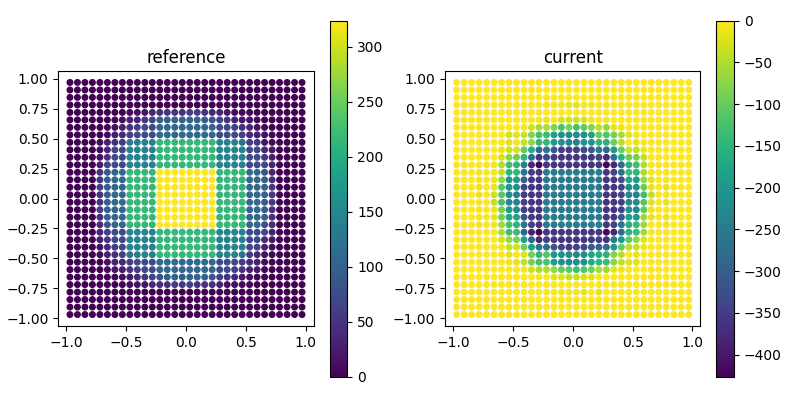

In [49]:
fig, axis = plt.subplots(1, 2, figsize = (8, 4), squeeze=False)


searchLevels_ = pointCloudY.supports / hCell
searchLevels_ = torch.floor(searchLevels_)
searchLevels_ = torch.clamp(searchLevels_, 0, levels)
# searchLevels = searchLevels.int() - 1

ratio = (numNeighbors) / numChecked

sc = axis[0,0].scatter(pointCloudX.positions[:,0], pointCloudX.positions[:,1], s = 16, c = numNeighbors)
fig.colorbar(sc, ax = axis[0,0])
axis[0,0].set_aspect('equal')
axis[0,0].set_title('reference')

sc = axis[0,1].scatter(pointCloudX.positions[:,0], pointCloudX.positions[:,1], s = 16, c = (numNeighbors - refNumNeighbors).cpu().numpy())
# sc = axis[0,1].scatter(pointCloudY.positions[:,0], pointCloudY.positions[:,1], s = 16, c = ratio)
fig.colorbar(sc, ax = axis[0,1])
axis[0,1].set_aspect('equal')
axis[0,1].set_title('current')

fig.tight_layout()

In [144]:
optimalRatio = 9 / np.pi
print(f'optimal ratio = {1/optimalRatio}')

optimal ratio = 0.3490658503988659


In [49]:
pos_i.view(1,-1)

tensor([[-0.4792, -0.4792]])

In [11]:

cooAdjacency = radiusSearch(pointCloudX, pointCloudY, algorithm = 'compact', domain = domainDescription, mode = 'symmetric')
print(cooAdjacency)


# print(i,j)

# cooNeighbors = SparseCOO(i, j, x.shape[0], y.shape[0])

# csrNeighbors = coo_to_csr(cooNeighbors, isSorted=False)
# cooNeighbors2 = csr_to_coo(csrNeighbors)

SparseCOO(row=tensor([167, 168, 168,  ..., 855, 856, 856]), col=tensor([  0,   1,   0,  ..., 573, 575, 574]), numRows=1024, numCols=576)


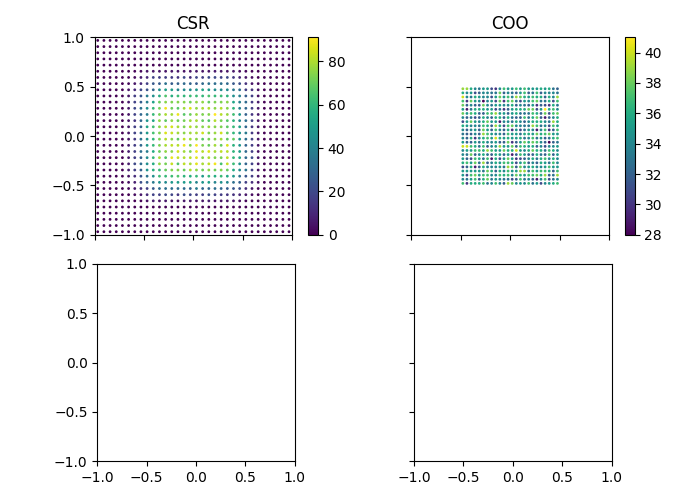

In [ ]:

_, numNeighborsI = countUniqueEntries(cooAdjacency.row, x)
_, numNeighborsJ = countUniqueEntries(cooAdjacency.col, y)

fig, ax = plt.subplots(2, 2, figsize = (7, 5), squeeze=False, sharey = True, sharex=True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)


pointCloudY2 = PointCloud(y, ySupport * 2)

sc = ax[0,0].scatter(pointCloudX.positions[:,0], pointCloudX.positions[:,1], cmap = 'viridis', c= numNeighborsI, s = 1)
plt.colorbar(sc, ax = ax[0,0])
ax[0,0].set_title('CSR')

sc = ax[0,1].scatter(pointCloudY.positions[:,0], pointCloudY.positions[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
plt.colorbar(sc, ax = ax[0,1])
ax[0,1].set_title('COO')


fig.tight_layout()

In [19]:
from sphMath.kernels import SPHKernel
from sphMath.kernels import getSPHKernel
from typing import Union, Tuple, Optional
from sphMath.sphOperations.shared import get_i, get_j, mod_distance, getSupport, scatter_sum, product

wrappedKernel = getSPHKernel('Wendland4')

In [32]:
positions = (pointCloudX.positions, pointCloudY.positions)
supports = (pointCloudX.supports, pointCloudY.supports)
i = cooAdjacency.row
j = cooAdjacency.col

periodicity = domainDescription.periodicity
minExtent = domainDescription.min
maxExtent = domainDescription.max

x_ij = mod_distance(get_i(positions, i), get_j(positions, j), periodicity, minExtent, maxExtent)

h_ij = getSupport(supports, i, j, mode = 'symmetric')


gradW_ij = wrappedKernel.jacobian(x_ij, h_ij)
# print(f'gradW_ij: {gradW_ij.min()}, {gradW_ij.max()}, {gradW_ij.mean()}')

W_ij = wrappedKernel.eval(x_ij, h_ij)
print(W_ij.min(), W_ij.max(), W_ij.mean())

tensor(2.2181e-32) tensor(78.4986) tensor(7.3461)


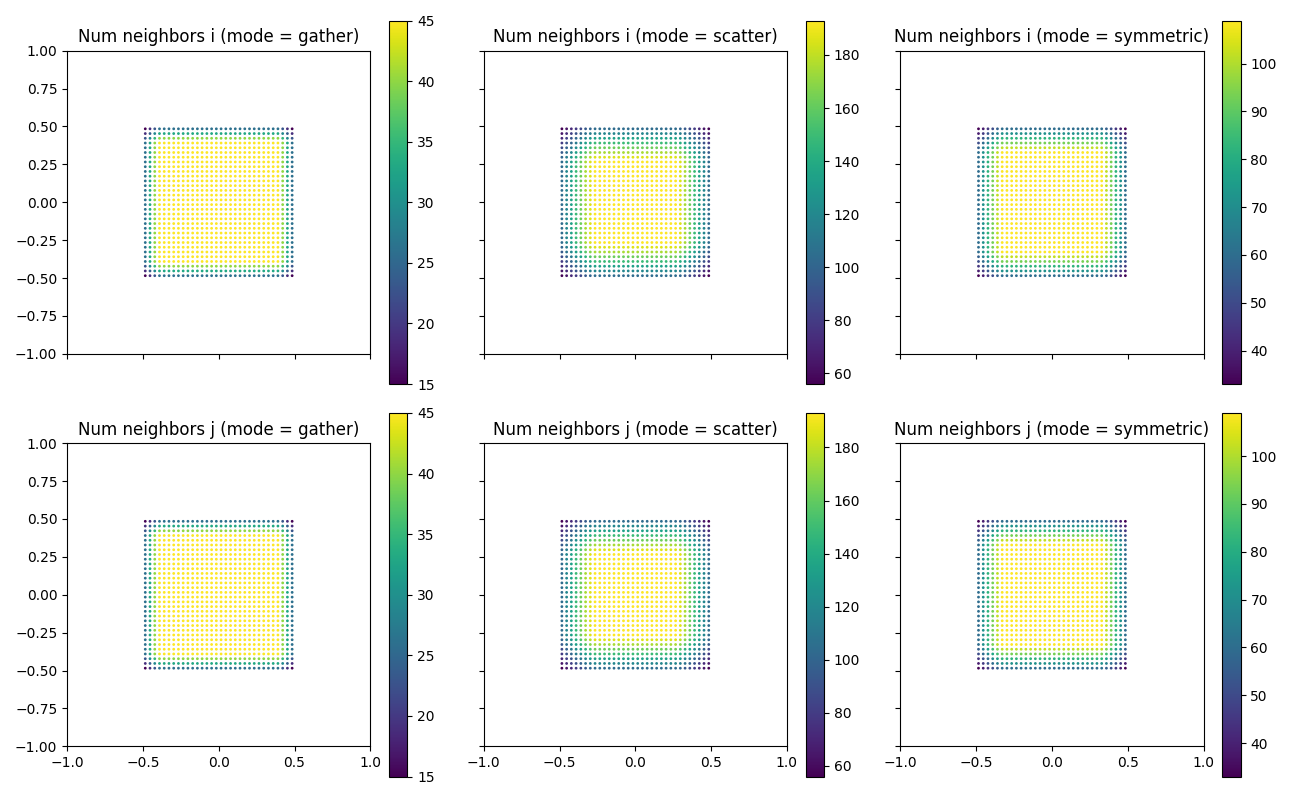

In [27]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2, 3, figsize = (13, 8), squeeze=False, sharey = True, sharex=True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)


pointCloudY2 = PointCloud(y, ySupport * 2)

for mi, mode in enumerate(['gather', 'scatter', 'symmetric']):

    i, j = radiusSearch(pointCloudY, pointCloudY2, algorithm = 'small', domain = domainDescription, mode = mode, verbose = False)
    jj, numNeighborsJ = countUniqueEntries(j, y)
    ii, numNeighborsI = countUniqueEntries(i, y)

    sc = ax[0,mi].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsI, s = 1)
    plt.colorbar(sc, ax = ax[0,mi])
    sc = ax[1,mi].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
    plt.colorbar(sc, ax = ax[1,mi])

    ax[0,mi].set_title(f'Num neighbors i (mode = {mode})')
    ax[1,mi].set_title(f'Num neighbors j (mode = {mode})')


fig.tight_layout()

torch.Size([28672]) torch.Size([28672]) tensor([167, 168, 168,  ..., 855, 855, 856]) tensor([167, 168, 168,  ..., 855, 855, 856])
torch.Size([28672]) torch.Size([28672]) tensor([   0,    1,    0,  ..., 1022, 1021, 1023]) tensor([   0,    1,    0,  ..., 1022, 1021, 1023])


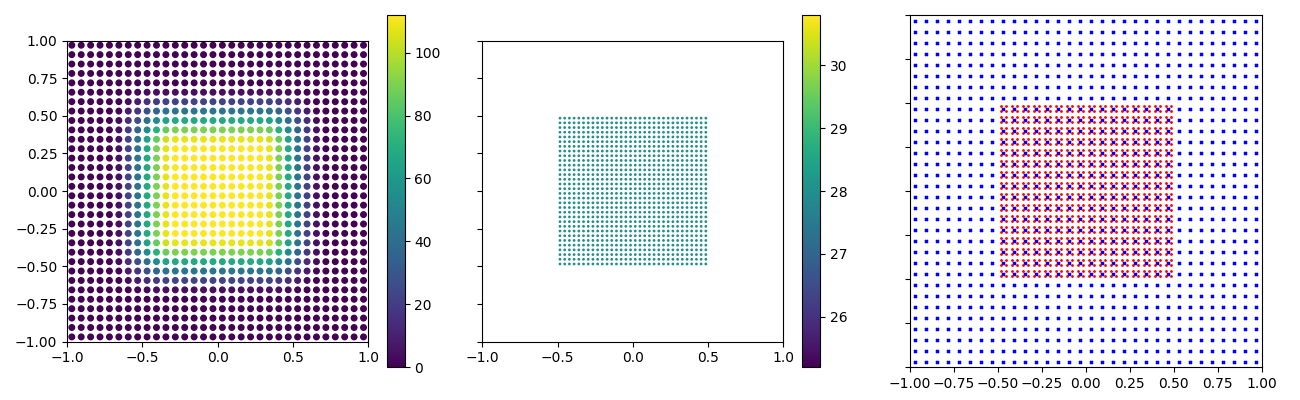

In [ ]:
from torchCompactRadius.compactHashing.datastructure import buildDataStructure
from torchCompactRadius import neighborSearchExisting
    
compactHashMap = buildDataStructure(pointCloudY, max(pointCloudX.supports.max().item(), pointCloudY.supports.max().item()), domainDescription, hashMapLength=4096)
i2,j2 = neighborSearchExisting(pointCloudX, compactHashMap, mode = 'symmetric')


# i, j, structure = radiusSearch(x, y, fixedSupport= torch.tensor(h, dtype = x.dtype, device = x.device), algorithm = 'small', domain = domainDescription, mode = 'gather', returnStructure=True)
i, j, compactHashMap = radiusSearch(pointCloudX, pointCloudY, algorithm = 'compact', domain = domainDescription, mode = 'symmetric', returnStructure=True)

print(i.shape, i2.shape, i, i2)
print(j.shape, j2.shape, j, j2)

assert torch.all(i == i2)
assert torch.all(j == j2)

jj, numNeighborsJ = countUniqueEntries(j, y)
ii, numNeighborsI = countUniqueEntries(i, x)

fig, ax = plt.subplots(1, 3, figsize = (13, 4), squeeze=False, sharey = True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)

sc = ax[0,0].scatter(x[:,0], x[:,1], cmap = 'viridis', c= numNeighborsI, s = 16)
plt.colorbar(sc, ax = ax[0,0])

sc = ax[0,1].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ, s = 1)
plt.colorbar(sc, ax = ax[0,1])

sc = ax[0,2].scatter(x[:,0], x[:,1], c = 'blue', marker = 'x', s = 4)
sc = ax[0,2].scatter(y[:,0], y[:,1], c = 'red', marker = 'o', s = 1)


fig.tight_layout()

torch.Size([28672]) torch.Size([28672])
torch.Size([28672]) torch.Size([28672])


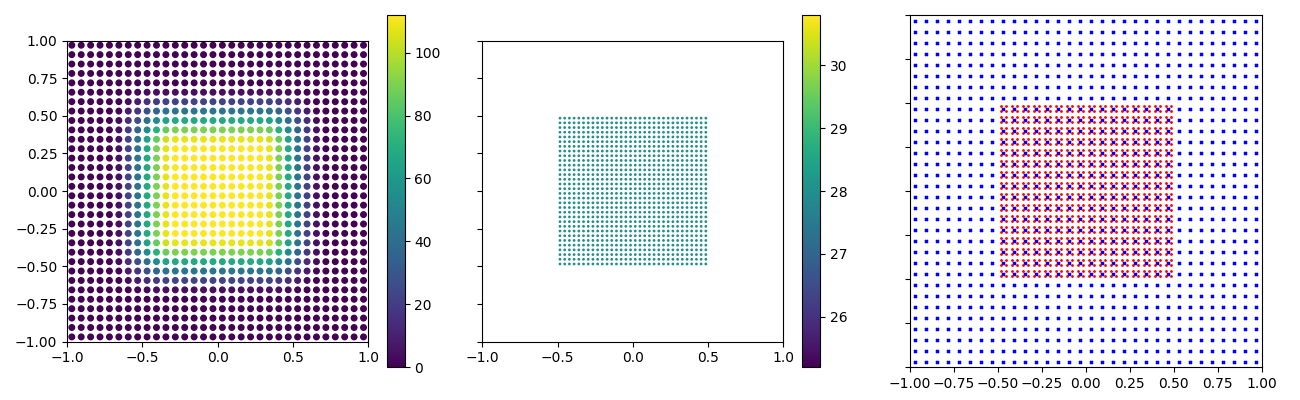

In [7]:
from torchCompactRadius.neighborhood import neighborSearchExisting
i2, j2 = neighborSearchExisting(pointCloudX, hashMap = compactHashMap, mode = 'symmetric', searchRadius = 1, variant = 'cpp', verbose = False)

print(i.shape, i2.shape)
print(j.shape, j2.shape)

jj2, numNeighborsJ2 = countUniqueEntries(j2, y)
ii2, numNeighborsI2 = countUniqueEntries(i2, x)

fig, ax = plt.subplots(1, 3, figsize = (13, 4), squeeze=False, sharey = True)

for axs in ax.flatten():
    axs.set_aspect('equal')
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)

sc = ax[0,0].scatter(x[:,0], x[:,1], cmap = 'viridis', c= numNeighborsI2, s = 16)
plt.colorbar(sc, ax = ax[0,0])

sc = ax[0,1].scatter(y[:,0], y[:,1], cmap = 'viridis', c= numNeighborsJ2, s = 1)
plt.colorbar(sc, ax = ax[0,1])

sc = ax[0,2].scatter(x[:,0], x[:,1], c = 'blue', marker = 'x', s = 4)
sc = ax[0,2].scatter(y[:,0], y[:,1], c = 'red', marker = 'o', s = 1)


fig.tight_layout()